In [3]:
import torch
import torch.nn as nn
from transformers import CLIPVisionModelWithProjection, ViTForImageClassification, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer, LlamaForCausalLM

import sys, os, json, math
from tqdm import tqdm
import numpy as np

from scipy.stats import pearsonr, spearmanr
from scipy.stats import kurtosis

import re
import matplotlib.pyplot as plt
std = 0.012528747320175171

--- Loading and processing model: Llama-3-8B ---


Loading checkpoint shards: 100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


Calculating weight stats for 32 layers...


Processing Layers: 100%|██████████| 32/32 [00:34<00:00,  1.09s/it]


--- Loading and processing model: LLama-2-7B ---


Loading checkpoint shards: 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


Calculating weight stats for 32 layers...


Processing Layers: 100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


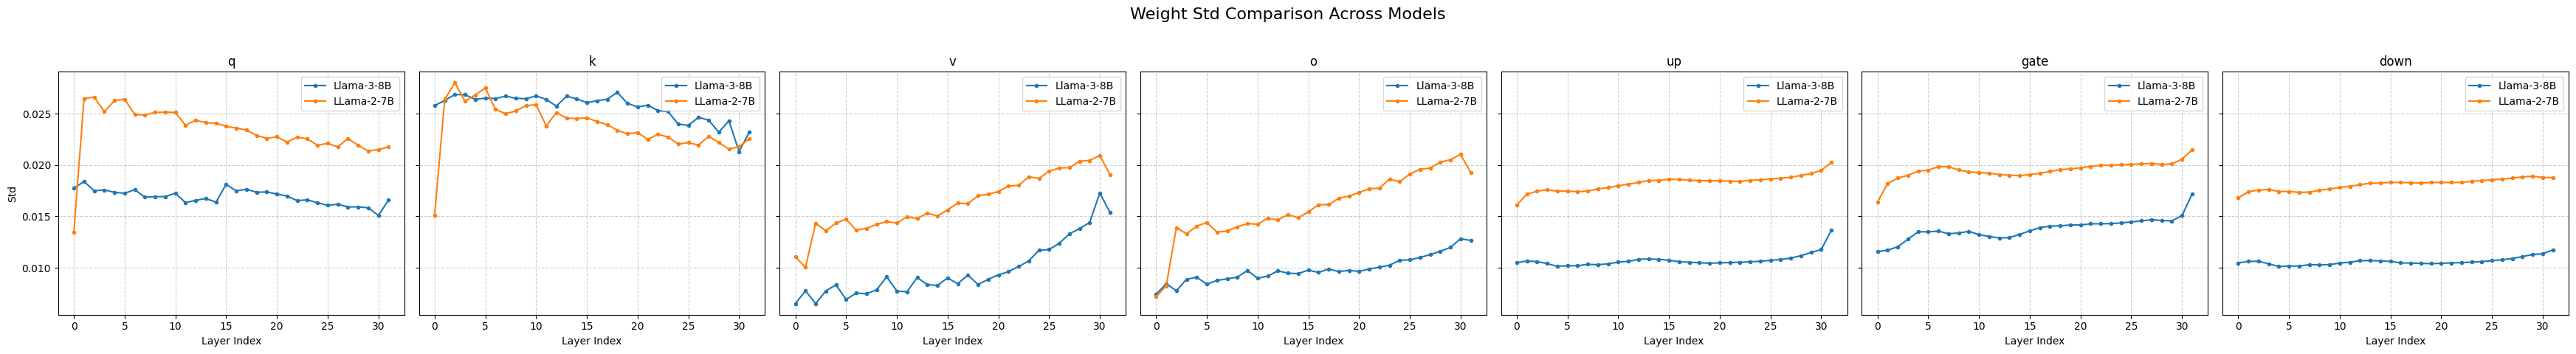

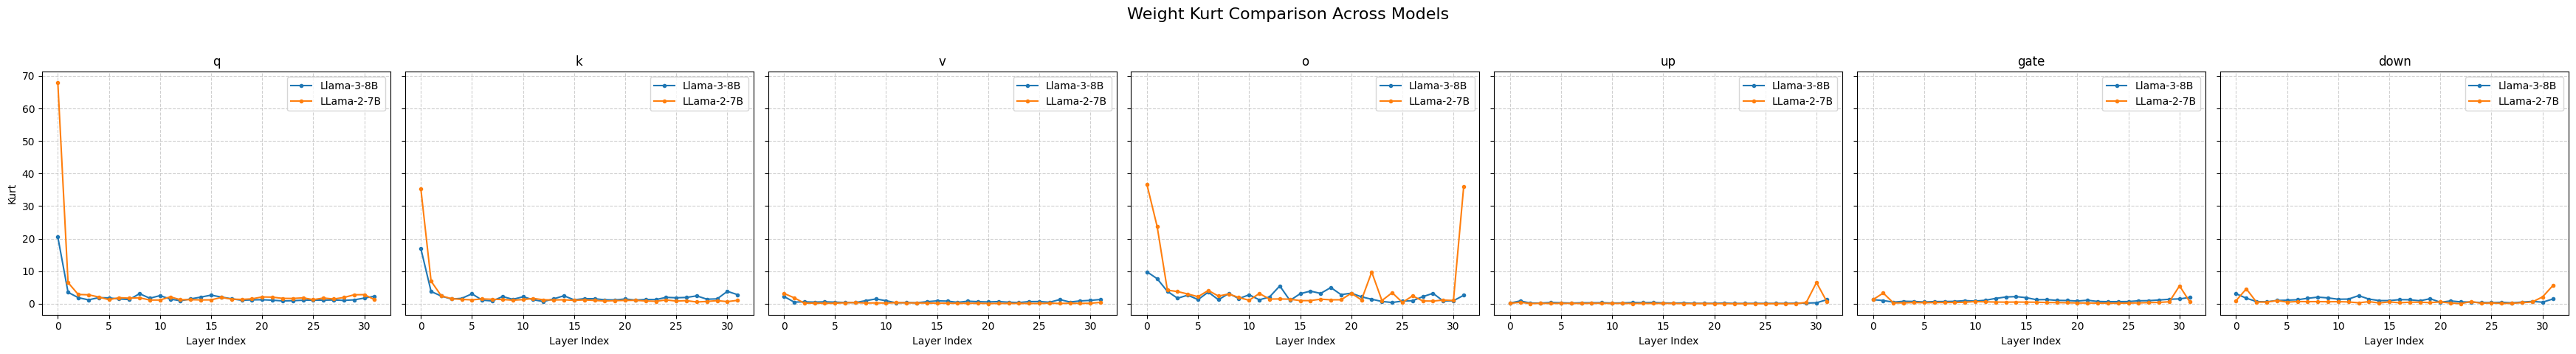

In [4]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM
from tqdm import tqdm
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np

# --- 1. 유틸리티 함수 (기존 코드와 거의 동일, 일부 수정) ---

def get_blocks(model):
    """모델 종류에 따라 Transformer 블록(레이어) 리스트를 반환합니다."""
    model_class = model.__class__.__name__
    if model_class in ("LlamaForCausalLM", "Qwen2ForCausalLM", "MistralForCausalLM"):
        return model.model.layers
    elif model_class == "LlavaLlamaForCausalLM":
        return model.model.layers
    # 여기에 다른 모델 아키텍처를 추가할 수 있습니다.
    # elif model_class == "SomeOtherModel":
    #     return model.transformer.h
    else:
        raise ValueError(f"Unsupported model class: {model_class}")

def get_named_linears(module):
    """모듈 내의 모든 nn.Linear 레이어를 이름과 함께 반환합니다."""
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_model_weight_stats(model):
    """
    주어진 모델의 각 레이어별 가중치 통계(표준편차, 첨도)를 계산하여 반환합니다.
    
    Args:
        model: 통계치를 계산할 PyTorch 모델 객체
        
    Returns:
        dict: {'std': {key: value}, 'kurt': {key: value}} 형태의 딕셔너리
    """
    stats = {'std': {}, 'kurt': {}}
    
    # Llama 계열 모델의 Linear 레이어 이름 매핑
    layer_name_map = {
        'self_attn.q_proj': 'q', 'self_attn.k_proj': 'k', 'self_attn.v_proj': 'v',
        'self_attn.o_proj': 'o', 'mlp.up_proj': 'up', 'mlp.gate_proj': 'gate',
        'mlp.down_proj': 'down',
    }
    
    try:
        layers = get_blocks(model)
        num_layers = len(layers)
    except (ValueError, AttributeError) as e:
        print(f"Could not get layers from model: {e}")
        return stats

    print(f"Calculating weight stats for {num_layers} layers...")
    for i in tqdm(range(num_layers), desc="Processing Layers"):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            if n in layer_name_map:
                w = m.weight.data.detach().float()
                
                # 통계 계산
                std_val = w.std().item()
                kurt_val = kurtosis(w.flatten().cpu().numpy(), fisher=True)
                
                # 결과 저장
                layer_type = layer_name_map[n]
                key = f'{i}_{layer_type}.pt'
                stats['std'][key] = std_val
                stats['kurt'][key] = kurt_val
                
    return stats

# --- 2. 메인 실행 로직 ---

def main():
    # --- 비교할 모델 목록 설정 ---
    models_to_compare = {
        "Llama-3-8B": "/workspace/Weight_compression/Wparam_dataset/hf_model/meta-llama--Meta-Llama-3-8B",
        'LLama-2-7B': "/workspace/Weight_compression/Wparam_dataset/hf_model/meta-llama--Llama-2-7b-hf",
    }
    
    all_stats = {}

    for model_name, model_path in models_to_compare.items():
        print(f"--- Loading and processing model: {model_name} ---")
        try:
            model = AutoModelForCausalLM.from_pretrained(
                model_path,
                torch_dtype='auto',
                low_cpu_mem_usage=True,
                # local_files_only=True, # 필요에 따라 주석 해제
                device_map = 'auto'
            )
            
            # 모델 통계 계산 및 저장
            model_stats = get_model_weight_stats(model)
            all_stats[model_name] = model_stats
            
        except Exception as e:
            print(f"Error processing model {model_name}: {e}")
        finally:
            # 메모리 관리를 위해 모델 삭제
            if 'model' in locals():
                del model
            torch.cuda.empty_cache()

    # --- 3. 비교 결과 시각화 ---
    
    lyr_list = ['q', 'k', 'v', 'o', 'up', 'gate', 'down']
    metrics_to_plot = ['std', 'kurt']

    for metric in metrics_to_plot:
        fig, axes = plt.subplots(1, len(lyr_list), figsize=(5 * len(lyr_list), 5), sharey=True)
        fig.suptitle(f'Weight {metric.capitalize()} Comparison Across Models', fontsize=16)

        for i, lyr_type in enumerate(lyr_list):
            ax = axes[i]
            
            # 각 모델에 대해 플로팅
            for model_name, stats_data in all_stats.items():
                if not stats_data[metric]: # 데이터가 없으면 건너뜀
                    continue

                # 레이어 인덱스와 값을 추출하여 리스트 생성
                layer_indices = []
                values = []
                
                # 모델의 전체 레이어 수를 동적으로 파악
                num_layers = 0
                if stats_data[metric].keys():
                    num_layers = max([int(k.split('_')[0]) for k in stats_data[metric].keys()]) + 1

                for idx in range(num_layers):
                    key = f'{idx}_{lyr_type}.pt'
                    if key in stats_data[metric]:
                        layer_indices.append(idx)
                        values.append(stats_data[metric][key])

                if values: # 플로팅할 데이터가 있을 경우에만 실행
                    ax.plot(layer_indices, values, marker='o', ms=3, linestyle='-', label=model_name)

            ax.set_title(lyr_type)
            ax.set_xlabel("Layer Index")
            if i == 0: # 첫 번째 그래프에만 Y축 라벨 표시
                ax.set_ylabel(metric.capitalize())
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


if __name__ == '__main__':
    main()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



==================== Processing model: Llama-3-8B ====================


Loading checkpoint shards: 100%|██████████| 7/7 [00:00<00:00, 10.49it/s]


Calculating per-layer weight stats for 32 layers...


Processing Layers: 100%|██████████| 32/32 [00:48<00:00,  1.50s/it]


Calculating global stats for the entire model...

==================== Processing model: LLama-2-7B ====================


Loading checkpoint shards: 100%|██████████| 6/6 [00:00<00:00,  9.82it/s]


Calculating per-layer weight stats for 32 layers...


Processing Layers: 100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Calculating global stats for the entire model...

                  Global Model Weight Stats

--- Model: Llama-3-8B ---
  - Overall Standard Deviation: 0.012529
  - Overall Kurtosis          : 3.093935

--- Model: LLama-2-7B ---
  - Overall Standard Deviation: 0.019240
  - Overall Kurtosis          : 1.575760



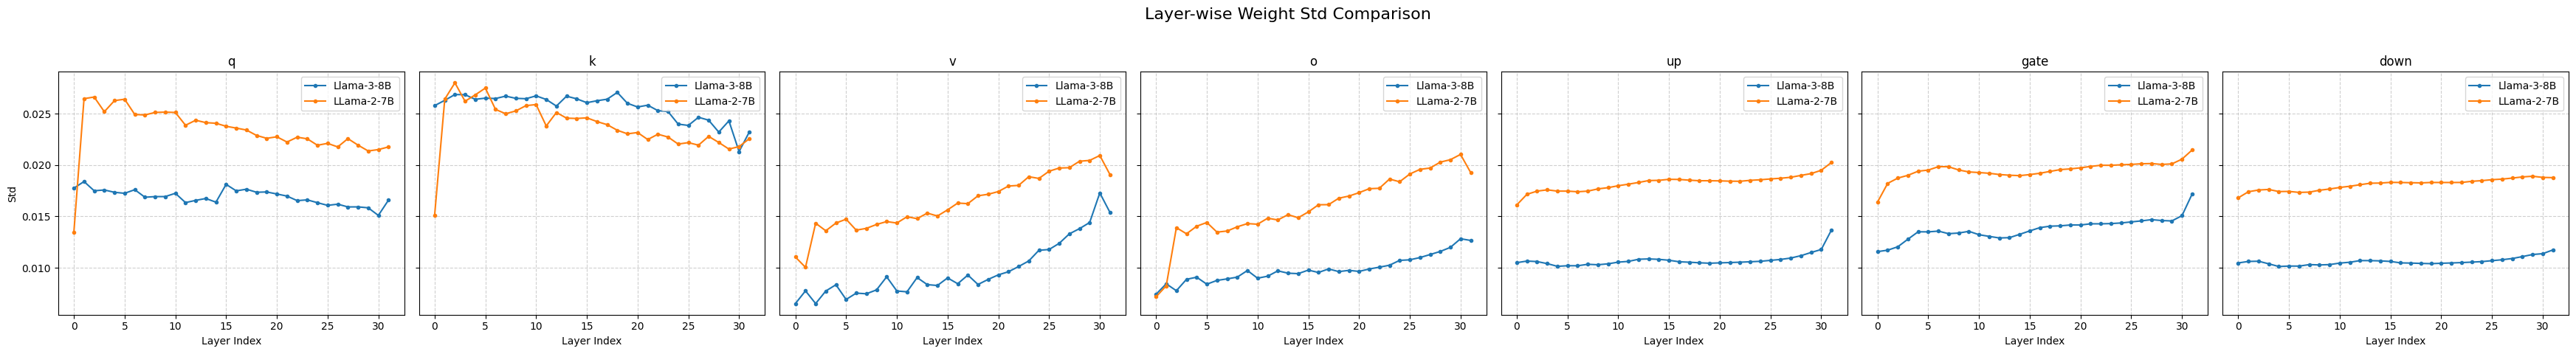

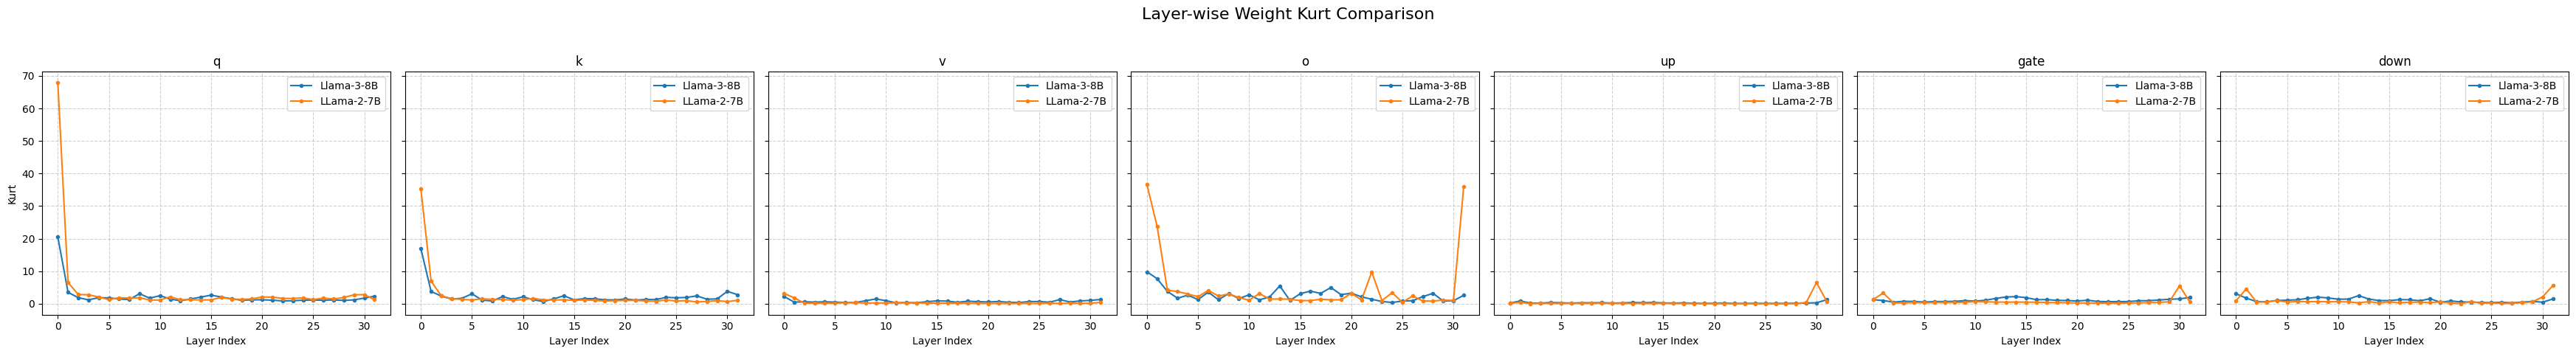

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM
from tqdm import tqdm
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

# --- 1. 유틸리티 함수 (전체 통계 계산 기능 추가) ---

def get_blocks(model):
    """모델 종류에 따라 Transformer 블록(레이어) 리스트를 반환합니다."""
    model_class = model.__class__.__name__
    if model_class in ("LlamaForCausalLM", "Qwen2ForCausalLM", "MistralForCausalLM"):
        return model.model.layers
    elif model_class == "LlavaLlamaForCausalLM":
        return model.model.layers
    else:
        raise ValueError(f"Unsupported model class: {model_class}")

def get_named_linears(module):
    """모듈 내의 모든 nn.Linear 레이어를 이름과 함께 반환합니다."""
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_model_weight_stats(model):
    """
    모델의 레이어별 및 전체 가중치 통계(표준편차, 첨도)를 계산합니다.
    
    Returns:
        dict: {'per_layer': {...}, 'global': {...}} 형태의 딕셔너리
    """
    # per_layer 통계를 저장할 딕셔너리
    per_layer_stats = {'std': {}, 'kurt': {}}
    # global 통계 계산을 위해 모든 가중치를 모을 리스트
    all_weights_list = []
    
    layer_name_map = {
        'self_attn.q_proj': 'q', 'self_attn.k_proj': 'k', 'self_attn.v_proj': 'v',
        'self_attn.o_proj': 'o', 'mlp.up_proj': 'up', 'mlp.gate_proj': 'gate',
        'mlp.down_proj': 'down',
    }
    
    try:
        layers = get_blocks(model)
        num_layers = len(layers)
    except (ValueError, AttributeError) as e:
        print(f"Could not get layers from model: {e}")
        return {'per_layer': per_layer_stats, 'global': {}}

    print(f"Calculating per-layer weight stats for {num_layers} layers...")
    for i in tqdm(range(num_layers), desc="Processing Layers"):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            if n in layer_name_map:
                w = m.weight.data.detach().float()
                all_weights_list.append(w.flatten()) # 전체 통계 계산을 위해 가중치 추가
                
                # 레이어별 통계 계산
                std_val = w.std().item()
                kurt_val = kurtosis(w.flatten().cpu().numpy(), fisher=True)
                
                layer_type = layer_name_map[n]
                key = f'{i}_{layer_type}.pt'
                per_layer_stats['std'][key] = std_val
                per_layer_stats['kurt'][key] = kurt_val

    # 모델 전체 가중치 통계 계산
    print("Calculating global stats for the entire model...")
    global_stats = {}
    if all_weights_list:
        # 모든 가중치를 하나의 텐서로 결합
        all_weights_tensor = torch.cat(all_weights_list)
        
        # 전체 표준편차
        global_stats['std'] = all_weights_tensor.std().item()
        
        # 전체 첨도
        # 매우 큰 텐서는 numpy 변환 시 메모리 문제를 일으킬 수 있으므로 주의
        weights_np = all_weights_tensor.cpu().numpy()
        global_stats['kurt'] = kurtosis(weights_np, fisher=True)
        del all_weights_tensor, weights_np # 메모리 정리
    else:
        global_stats['std'] = 0
        global_stats['kurt'] = 0

    return {'per_layer': per_layer_stats, 'global': global_stats}

# --- 2. 메인 실행 로직 ---

def main():
    # --- 비교할 모델 목록 설정 ---
    models_to_compare = {
        "Llama-3-8B": "/workspace/Weight_compression/Wparam_dataset/hf_model/meta-llama--Meta-Llama-3-8B",
        # 'LLama-2-7B': "/workspace/Weight_compression/Wparam_dataset/hf_model/meta-llama--Llama-2-7b-hf",
        # "Qwen2-7B": "/path/to/your/qwen2-7b/model", 
    }
    
    all_stats = {}

    for model_name, model_path in models_to_compare.items():
        print(f"\n{'='*20} Processing model: {model_name} {'='*20}")
        try:
            model = AutoModelForCausalLM.from_pretrained(
                model_path,
                torch_dtype='auto',
                # device_map="auto",
            )
            
            model_results = get_model_weight_stats(model)
            all_stats[model_name] = model_results
            
        except Exception as e:
            print(f"Error processing model {model_name}: {e}")
        finally:
            if 'model' in locals():
                del model
            torch.cuda.empty_cache()

    # --- 3. 모델 전체 통계 출력 ---
    print("\n" + "="*60)
    print(" " * 18 + "Global Model Weight Stats")
    print("="*60)
    for model_name, results in all_stats.items():
        global_stats = results.get('global', {})
        std = global_stats.get('std', 'N/A')
        kurt = global_stats.get('kurt', 'N/A')
        print(f"\n--- Model: {model_name} ---")
        if isinstance(std, float):
            print(f"  - Overall Standard Deviation: {std:.6f}")
            print(f"  - Overall Kurtosis          : {kurt:.6f}")
        else:
            print(f"  - Stats not available.")
    print("="*60 + "\n")


    # --- 4. 레이어별 통계 비교 시각화 ---
    lyr_list = ['q', 'k', 'v', 'o', 'up', 'gate', 'down']
    metrics_to_plot = ['std', 'kurt']

    for metric in metrics_to_plot:
        fig, axes = plt.subplots(1, len(lyr_list), figsize=(5 * len(lyr_list), 5), sharey=True)
        fig.suptitle(f'Layer-wise Weight {metric.capitalize()} Comparison', fontsize=16)

        for i, lyr_type in enumerate(lyr_list):
            ax = axes[i]
            
            for model_name, results in all_stats.items():
                stats_data = results['per_layer'] # 변경된 구조에 맞게 접근
                if not stats_data.get(metric):
                    continue

                layer_indices, values = [], []
                num_layers = 0
                if stats_data[metric].keys():
                    num_layers = max([int(k.split('_')[0]) for k in stats_data[metric].keys()]) + 1

                for idx in range(num_layers):
                    key = f'{idx}_{lyr_type}.pt'
                    if key in stats_data[metric]:
                        layer_indices.append(idx)
                        values.append(stats_data[metric][key])

                if values:
                    ax.plot(layer_indices, values, marker='o', ms=3, linestyle='-', label=model_name)

            ax.set_title(lyr_type)
            ax.set_xlabel("Layer Index")
            if i == 0:
                ax.set_ylabel(metric.capitalize())
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


if __name__ == '__main__':
    main()


==================== Processing model: Llama-3-8B ====================


Loading checkpoint shards: 100%|██████████| 7/7 [00:00<00:00,  9.19it/s]


Pass 1: Calculating global standard deviation...


Pass 1/2: 100%|██████████| 32/32 [00:00<00:00, 15799.61it/s]


Pass 2: Calculating stats for all normalization cases...


Pass 2/2: 100%|██████████| 32/32 [03:18<00:00,  6.22s/it]



              Global Model Weight Stats (Raw)

--- Model: Llama-3-8B ---
  - Overall Standard Deviation: 0.012529
  - Overall Kurtosis          : 3.093935



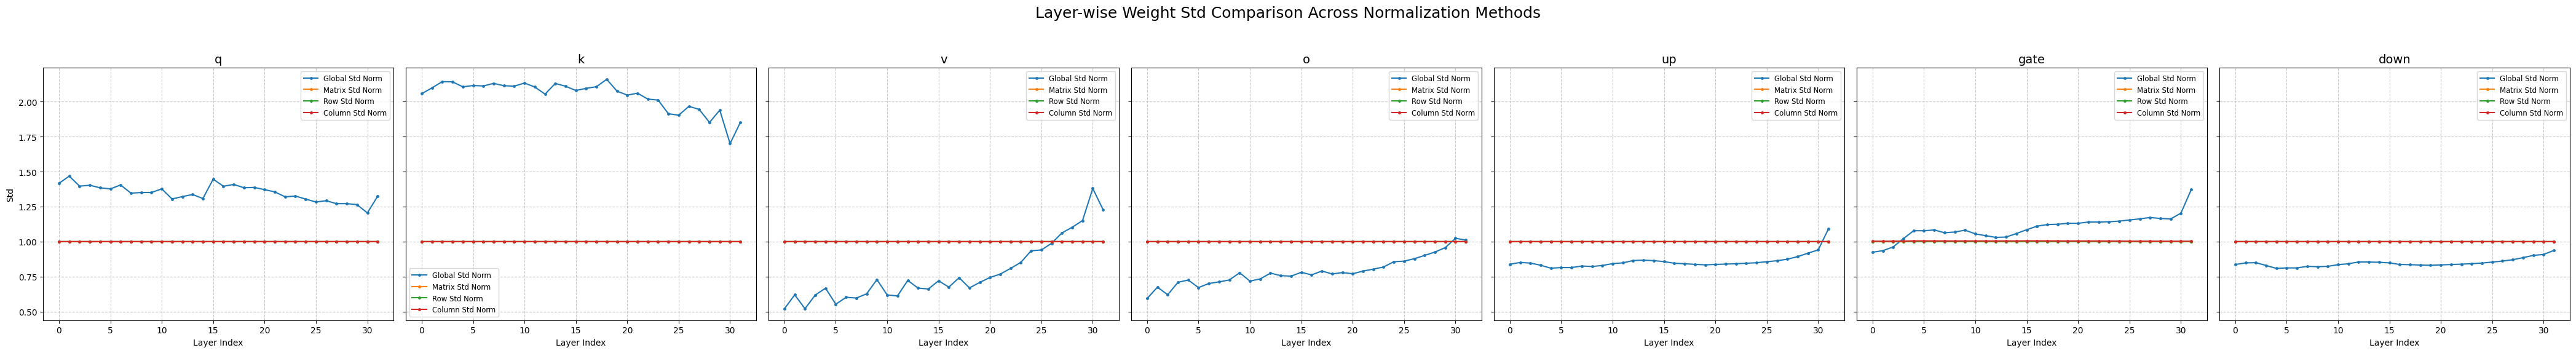

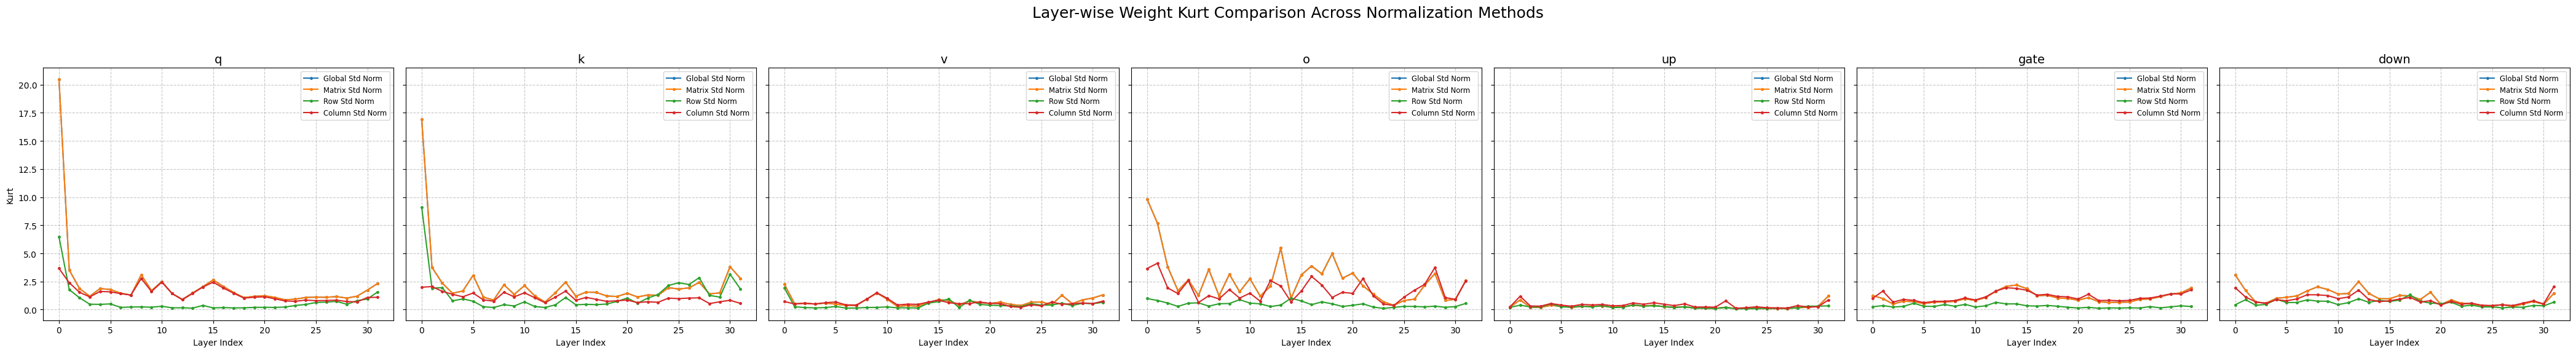

In [4]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM
from tqdm import tqdm
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import gc

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

# --- 1. 유틸리티 함수 (이전과 동일) ---

def get_blocks(model):
    """모델 종류에 따라 Transformer 블록(레이어) 리스트를 반환합니다."""
    model_class = model.__class__.__name__
    if model_class in ("LlamaForCausalLM", "Qwen2ForCausalLM", "MistralForCausalLM"):
        return model.model.layers
    elif model_class == "LlavaLlamaForCausalLM":
        return model.model.layers
    else:
        raise ValueError(f"Unsupported model class: {model_class}")

def get_named_linears(module):
    """모듈 내의 모든 nn.Linear 레이어를 이름과 함께 반환합니다."""
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def calculate_stats(tensor):
    """주어진 텐서의 표준편차와 첨도를 계산합니다."""
    if tensor.numel() == 0:
        return 0.0, 0.0
    
    std_val = tensor.std().item()
    
    if tensor.is_cuda:
        tensor_cpu = tensor.flatten().cpu().numpy()
    else:
        tensor_cpu = tensor.flatten().numpy()
        
    kurt_val = kurtosis(tensor_cpu, fisher=True)
    return std_val, kurt_val

def get_model_weight_stats(model):
    """
    모델 가중치에 대해 5가지 케이스(원본, 4가지 정규화)의 통계를 계산합니다.
    """
    layer_name_map = {
        'self_attn.q_proj': 'q', 'self_attn.k_proj': 'k', 'self_attn.v_proj': 'v',
        'self_attn.o_proj': 'o', 'mlp.up_proj': 'up', 'mlp.gate_proj': 'gate',
        'mlp.down_proj': 'down',
    }
    
    try:
        layers = get_blocks(model)
        num_layers = len(layers)
    except (ValueError, AttributeError) as e:
        print(f"Could not get layers from model: {e}")
        return {}

    # --- Pass 1: Global std 계산 ---
    print("Pass 1: Calculating global standard deviation...")
    all_weights_list = []
    for i in tqdm(range(num_layers), desc="Pass 1/2"):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            if n in layer_name_map:
                w = m.weight.data.detach().float()
                all_weights_list.append(w.flatten())
    
    global_stats = {}
    if all_weights_list:
        all_weights_tensor = torch.cat(all_weights_list)
        global_std, global_kurt = calculate_stats(all_weights_tensor)
        global_stats = {'std': global_std, 'kurt': global_kurt}
        del all_weights_tensor
    else:
        global_stats = {'std': 1.0, 'kurt': 0.0}
    
    del all_weights_list
    gc.collect()

    # --- Pass 2: 모든 케이스에 대한 통계 계산 ---
    print("Pass 2: Calculating stats for all normalization cases...")
    
    norm_keys = ['raw', 'norm_global', 'norm_matrix', 'norm_row', 'norm_col']
    per_layer_stats = {key: {'std': {}, 'kurt': {}} for key in norm_keys}
    epsilon = 1e-8

    for i in tqdm(range(num_layers), desc="Pass 2/2"):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            if n in layer_name_map:
                w = m.weight.data.detach().float()
                layer_type = layer_name_map[n]
                stat_key = f'{i}_{layer_type}.pt'

                # 1. 원본 (Raw)
                std, kurt = calculate_stats(w)
                per_layer_stats['raw']['std'][stat_key] = std
                per_layer_stats['raw']['kurt'][stat_key] = kurt

                # 2. Global Std로 정규화
                std, kurt = calculate_stats(w / (global_stats['std'] + epsilon))
                per_layer_stats['norm_global']['std'][stat_key] = std
                per_layer_stats['norm_global']['kurt'][stat_key] = kurt

                # 3. Matrix Std로 정규화
                matrix_std = w.std().item()
                std, kurt = calculate_stats(w / (matrix_std + epsilon))
                per_layer_stats['norm_matrix']['std'][stat_key] = std
                per_layer_stats['norm_matrix']['kurt'][stat_key] = kurt

                # 4. Row-wise Std로 정규화
                row_stds = w.std(dim=1, keepdim=True)
                w_norm_row = w / (row_stds + epsilon)
                std, kurt = calculate_stats(w_norm_row)
                per_layer_stats['norm_row']['std'][stat_key] = std
                per_layer_stats['norm_row']['kurt'][stat_key] = kurt
                del w_norm_row

                # 5. Column-wise Std로 정규화
                col_stds = w.std(dim=0, keepdim=True)
                w_norm_col = w / (col_stds + epsilon)
                std, kurt = calculate_stats(w_norm_col)
                per_layer_stats['norm_col']['std'][stat_key] = std
                per_layer_stats['norm_col']['kurt'][stat_key] = kurt
                del w_norm_col

    return {'per_layer': per_layer_stats, 'global': global_stats}

# --- 2. 메인 실행 로직 ---


# --- 비교할 모델 목록 설정 ---
models_to_compare = {
    "Llama-3-8B": "/workspace/Weight_compression/Wparam_dataset/hf_model/meta-llama--Meta-Llama-3-8B",
    # 'LLama-2-7B': "/workspace/Weight_compression/Wparam_dataset/hf_model/meta-llama--Llama-2-7b-hf",
}

all_stats = {}

for model_name, model_path in models_to_compare.items():
    print(f"\n{'='*20} Processing model: {model_name} {'='*20}")
    try:
        model = AutoModelForCausalLM.from_pretrained(
            model_path,
            torch_dtype='auto',
            low_cpu_mem_usage=True, 
        )
        
        model_results = get_model_weight_stats(model)
        all_stats[model_name] = model_results
        
    except Exception as e:
        print(f"Error processing model {model_name}: {e}")
    finally:
        if 'model' in locals():
            del model
        gc.collect()
        torch.cuda.empty_cache()

# --- 3. 모델 전체 (원본) 통계 출력 (이전과 동일) ---
print("\n" + "="*60)
print(" " * 14 + "Global Model Weight Stats (Raw)")
print("="*60)
# ... (이 부분은 수정할 필요 없음)
for model_name, results in all_stats.items():
    global_stats = results.get('global', {})
    std = global_stats.get('std', 'N/A')
    kurt = global_stats.get('kurt', 'N/A')
    print(f"\n--- Model: {model_name} ---")
    if isinstance(std, float):
        print(f"  - Overall Standard Deviation: {std:.6f}")
        print(f"  - Overall Kurtosis          : {kurt:.6f}")
    else:
        print(f"  - Stats not available.")
print("="*60 + "\n")


# --- 4. 정규화 케이스 비교 시각화 (수정된 부분) ---
lyr_list = ['q', 'k', 'v', 'o', 'up', 'gate', 'down']
metrics_to_plot = ['std', 'kurt']
# 'raw'를 제외하고 비교할 정규화 케이스 정의
norm_cases_to_compare = {
    'norm_global': 'Global Std Norm',
    'norm_matrix': 'Matrix Std Norm',
    'norm_row': 'Row Std Norm',
    'norm_col': 'Column Std Norm'
}

# 통계 지표(std, kurt) 별로 Figure 생성
for metric in metrics_to_plot:
    # figsize을 조정하여 더 넓은 그래프 생성
    fig, axes = plt.subplots(1, len(lyr_list), figsize=(6 * len(lyr_list), 6), sharey=True)
    fig.suptitle(f'Layer-wise Weight {metric.capitalize()} Comparison Across Normalization Methods', fontsize=18)

    # 각 서브플롯 (q, k, v...)에 대해
    for i, lyr_type in enumerate(lyr_list):
        ax = axes[i]
        
        # 각 정규화 케이스에 대해 라인을 그림
        for norm_key, norm_label in norm_cases_to_compare.items():
            
            # (여러 모델을 비교할 경우를 위해 유지)
            for model_name, results in all_stats.items():
                stats_data = results['per_layer'][norm_key]
                if not stats_data.get(metric):
                    continue

                layer_indices, values = [], []
                num_layers = 0
                if stats_data[metric].keys():
                    num_layers = max([int(k.split('_')[0]) for k in stats_data[metric].keys()]) + 1

                for idx in range(num_layers):
                    key = f'{idx}_{lyr_type}.pt'
                    if key in stats_data[metric]:
                        layer_indices.append(idx)
                        values.append(stats_data[metric][key])

                if values:
                    # 여러 모델을 비교할 때를 대비해 라벨에 모델 이름도 포함
                    label = f"{model_name.split('-')[0]} ({norm_label})" if len(all_stats) > 1 else norm_label
                    ax.plot(layer_indices, values, marker='o', ms=2.5, linestyle='-', label=label)

        ax.set_title(lyr_type, fontsize=14)
        ax.set_xlabel("Layer Index")
        if i == 0:
            ax.set_ylabel(metric.capitalize())
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(fontsize='small')

    plt.tight_layout(rect=[0, 0.03, 1, 0.94]) # suptitle과 겹치지 않도록 rect 조정
    plt.show()


In [13]:
all_stats['Llama-3-8B']['per_layer']['norm_global']['kurt']

{'0_q.pt': 20.477999471785708,
 '0_k.pt': 16.910793133702498,
 '0_v.pt': 2.2438045470802646,
 '0_o.pt': 9.816670889406458,
 '0_gate.pt': 1.2539804300504551,
 '0_up.pt': 0.19603423656971142,
 '0_down.pt': 3.0780911877443193,
 '1_q.pt': 3.5184048200419253,
 '1_k.pt': 3.7627613681900334,
 '1_v.pt': 0.5119520209931223,
 '1_o.pt': 7.695648901789125,
 '1_gate.pt': 0.9816360586605914,
 '1_up.pt': 0.8657748152594547,
 '1_down.pt': 1.7056303278045526,
 '2_q.pt': 1.870905820931151,
 '2_k.pt': 2.3585052396975943,
 '2_v.pt': 0.5811272072019484,
 '2_o.pt': 3.8049454913397387,
 '2_gate.pt': 0.4928554439780224,
 '2_up.pt': 0.19869777748377748,
 '2_down.pt': 0.6681285359772873,
 '3_q.pt': 1.1911654027945113,
 '3_k.pt': 1.4501563051394815,
 '3_v.pt': 0.4987831042247439,
 '3_o.pt': 1.6856238936414814,
 '3_gate.pt': 0.7501712413225952,
 '3_up.pt': 0.20137607311970873,
 '3_down.pt': 0.5819340628449492,
 '4_q.pt': 1.8743473960855175,
 '4_k.pt': 1.655816176337357,
 '4_v.pt': 0.5834793894232062,
 '4_o.pt': 2

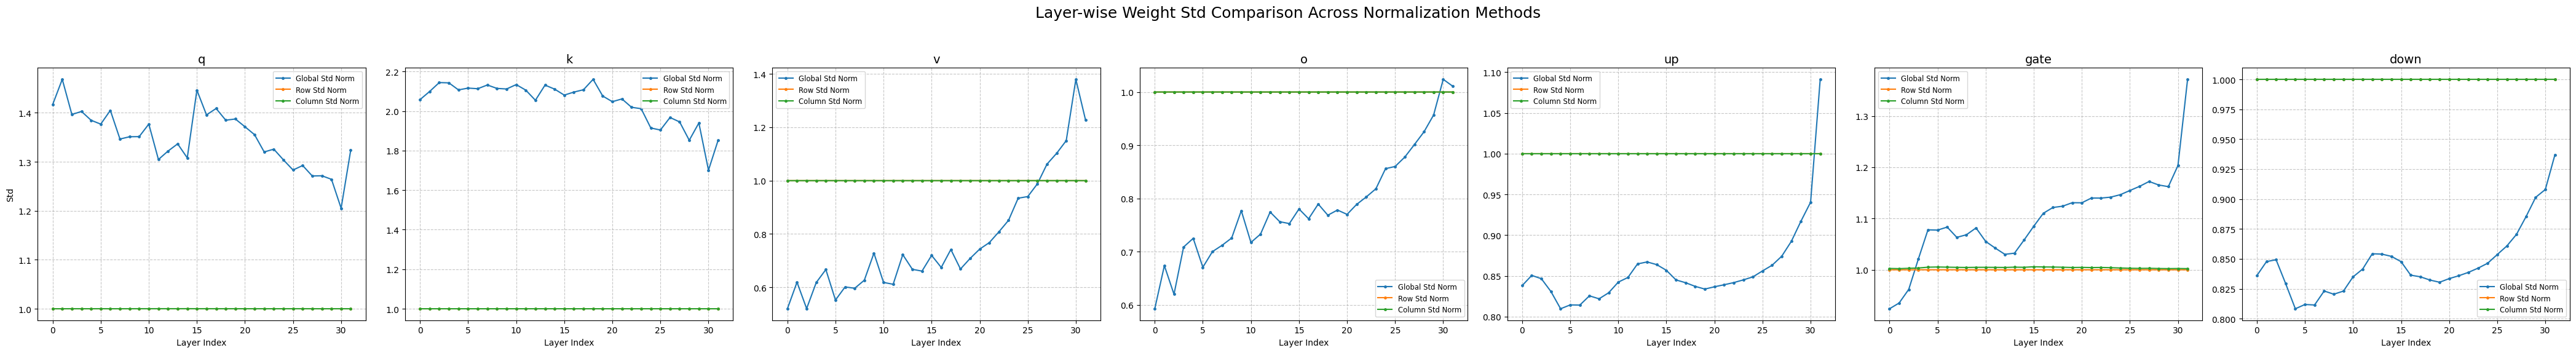

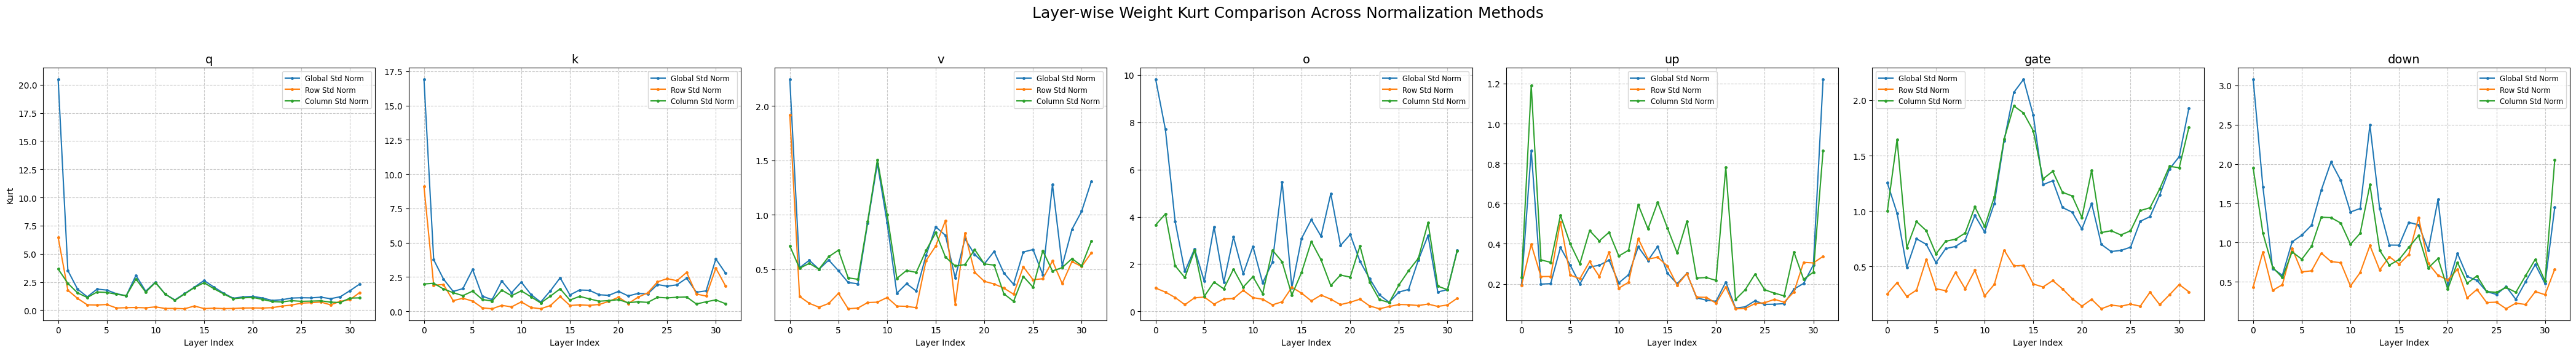

In [16]:
for metric in metrics_to_plot:
    # figsize을 조정하여 더 넓은 그래프 생성
    fig, axes = plt.subplots(1, len(lyr_list), figsize=(6 * len(lyr_list), 6), sharey=False)
    fig.suptitle(f'Layer-wise Weight {metric.capitalize()} Comparison Across Normalization Methods', fontsize=18)

    # 각 서브플롯 (q, k, v...)에 대해
    for i, lyr_type in enumerate(lyr_list):
        ax = axes[i]
        
        # 각 정규화 케이스에 대해 라인을 그림
        for norm_key, norm_label in norm_cases_to_compare.items():
            if norm_key == 'norm_matrix': continue
            # (여러 모델을 비교할 경우를 위해 유지)
            for model_name, results in all_stats.items():
                stats_data = results['per_layer'][norm_key]
                if not stats_data.get(metric):
                    continue

                layer_indices, values = [], []
                num_layers = 0
                if stats_data[metric].keys():
                    num_layers = max([int(k.split('_')[0]) for k in stats_data[metric].keys()]) + 1

                for idx in range(num_layers):
                    key = f'{idx}_{lyr_type}.pt'
                    if key in stats_data[metric]:
                        layer_indices.append(idx)
                        values.append(stats_data[metric][key])

                if values:
                    # 여러 모델을 비교할 때를 대비해 라벨에 모델 이름도 포함
                    label = f"{model_name.split('-')[0]} ({norm_label})" if len(all_stats) > 1 else norm_label
                    ax.plot(layer_indices, values, marker='o', ms=2.5, linestyle='-', label=label)

        ax.set_title(lyr_type, fontsize=14)
        ax.set_xlabel("Layer Index")
        if i == 0:
            ax.set_ylabel(metric.capitalize())
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(fontsize='small')

    plt.tight_layout(rect=[0, 0.03, 1, 0.94]) # suptitle과 겹치지 않도록 rect 조정
    plt.show()


In [19]:
def calculate_normalized_global_kurtosis(model, global_raw_stats):
    """
    4가지 정규화 케이스 각각에 대한 Global Kurtosis를 계산합니다. (기존 Pass 3)
    """
    print("\nCalculating global kurtosis for each normalized case...")
    
    layer_name_map = {
        'self_attn.q_proj': 'q', 'self_attn.k_proj': 'k', 'self_attn.v_proj': 'v',
        'self_attn.o_proj': 'o', 'mlp.up_proj': 'up', 'mlp.gate_proj': 'gate',
        'mlp.down_proj': 'down',
    }
    layers = get_blocks(model)
    num_layers = len(layers)
    epsilon = 1e-8
    
    global_normalized_stats = {}
    norm_keys_to_calc = ['norm_global', 'norm_matrix', 'norm_row', 'norm_col']

    for norm_key in norm_keys_to_calc:
        temp_weights_list = []
        for i in tqdm(range(num_layers), desc=f"Calculating Global Kurt ({norm_key})"):
            for n, m in get_named_linears(layers[i]).items():
                if n in layer_name_map:
                    w = m.weight.data.detach().float()
                    
                    if norm_key == 'norm_global':
                        w_norm = w / (global_raw_stats['std'] + epsilon)
                    elif norm_key == 'norm_matrix':
                        w_norm = w / (w.std().item() + epsilon)
                    elif norm_key == 'norm_row':
                        w_norm = w / (w.std(dim=1, keepdim=True) + epsilon)
                    elif norm_key == 'norm_col':
                        w_norm = w / (w.std(dim=0, keepdim=True) + epsilon)
                    
                    temp_weights_list.append(w_norm.flatten())

        all_norm_weights = torch.cat(temp_weights_list)
        _, kurt_val = calculate_stats(all_norm_weights)
        global_normalized_stats[norm_key] = {'kurt': kurt_val}
        
        del temp_weights_list, all_norm_weights
        gc.collect()
        
    return global_normalized_stats


models_to_compare = {
    "Llama-3-8B": "/workspace/Weight_compression/Wparam_dataset/hf_model/meta-llama--Meta-Llama-3-8B",
}

for model_name, model_path in models_to_compare.items():
    print(f"\n{'='*20} Processing model: {model_name} {'='*20}")
    model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype='auto', low_cpu_mem_usage=True)
    
    # 1. Pass 1, 2 수행
    
    # 2. Pass 3 (별도 함수) 수행
    normalized_global_kurt = calculate_normalized_global_kurtosis(model, all_stats['global_raw'])
    
    # 3. 모든 결과 취합
    all_stats[model_name] = {
        'per_layer': all_stats['per_layer'],
        'global_raw': all_stats['global_raw'],
        'global_normalized': normalized_global_kurt
        }
# --- 결과 출력 부분 ---
# 3a. 원본(Raw) Global 통계 출력
print("\n" + "="*60)
print(" " * 14 + "Global Model Weight Stats (Raw)")
print("="*60)
for model_name, results in all_stats.items():
    global_stats = results.get('global_raw', {})
    std = global_stats.get('std', 'N/A')
    kurt = global_stats.get('kurt', 'N/A')
    print(f"\n--- Model: {model_name} ---")
    if isinstance(std, float):
        print(f"  - Overall Standard Deviation: {std:.6f}")
        print(f"  - Overall Kurtosis          : {kurt:.6f}")
    else:
        print(f"  - Stats not available.")
print("="*60)

# 3b. 정규화 후 Global Kurtosis 출력
norm_cases_map = {
    'norm_global': 'Global Std Norm', 'norm_matrix': 'Matrix Std Norm',
    'norm_row': 'Row Std Norm', 'norm_col': 'Column Std Norm'
}
print("\n" + "="*60)
print(" " * 12 + "Global Kurtosis After Normalization")
print("="*60)
for model_name, results in all_stats.items():
    print(f"\n--- Model: {model_name} ---")
    norm_stats = results.get('global_normalized', {})
    if not norm_stats:
        print("  - No normalized global stats available.")
        continue
    
    for norm_key, stats in norm_stats.items():
        label = norm_cases_map.get(norm_key, norm_key)
        kurt = stats.get('kurt', 'N/A')
        print(f"  - Kurtosis ({label:17}): {kurt:9.4f}")
print("="*60 + "\n")



==================== Processing model: Llama-3-8B ====================


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 7/7 [00:01<00:00,  5.83it/s]


KeyError: 'global_raw'

In [20]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM
from tqdm import tqdm
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import gc

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

# --- 1. 유틸리티 함수 (이전과 동일) ---

def get_blocks(model):
    """모델 종류에 따라 Transformer 블록(레이어) 리스트를 반환합니다."""
    model_class = model.__class__.__name__
    if model_class in ("LlamaForCausalLM", "Qwen2ForCausalLM", "MistralForCausalLM"):
        return model.model.layers
    elif model_class == "LlavaLlamaForCausalLM":
        return model.model.layers
    else:
        raise ValueError(f"Unsupported model class: {model_class}")

def get_named_linears(module):
    """모듈 내의 모든 nn.Linear 레이어를 이름과 함께 반환합니다."""
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def calculate_stats(tensor):
    """주어진 텐서의 표준편차와 첨도를 계산합니다."""
    if tensor.numel() == 0:
        return 0.0, 0.0
    
    std_val = tensor.std().item()
    
    if tensor.is_cuda:
        tensor_cpu = tensor.flatten().cpu().numpy()
    else:
        tensor_cpu = tensor.flatten().numpy()
        
    kurt_val = kurtosis(tensor_cpu, fisher=True)
    return std_val, kurt_val

def get_model_weight_stats(model):
    """
    모델 가중치에 대해 레이어별 통계 및 모든 케이스의 Global Kurtosis를 계산합니다.
    """
    layer_name_map = {
        'self_attn.q_proj': 'q', 'self_attn.k_proj': 'k', 'self_attn.v_proj': 'v',
        'self_attn.o_proj': 'o', 'mlp.up_proj': 'up', 'mlp.gate_proj': 'gate',
        'mlp.down_proj': 'down',
    }
    
    try:
        layers = get_blocks(model)
        num_layers = len(layers)
    except (ValueError, AttributeError) as e:
        print(f"Could not get layers from model: {e}")
        return {}

    # --- Pass 1: Global Raw Stats 계산 ---
    print("Pass 1: Calculating global standard deviation...")
    all_weights_list = []
    for i in tqdm(range(num_layers), desc="Pass 1 (Global Raw Stats)"):
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            if n in layer_name_map:
                w = m.weight.data.detach().float()
                all_weights_list.append(w.flatten())
    
    global_raw_stats = {}
    if all_weights_list:
        all_weights_tensor = torch.cat(all_weights_list)
        global_std, global_kurt = calculate_stats(all_weights_tensor)
        global_raw_stats = {'std': global_std, 'kurt': global_kurt}
        del all_weights_tensor
    else:
        global_raw_stats = {'std': 1.0, 'kurt': 0.0}
    
    del all_weights_list
    gc.collect()

    # --- Pass 2: Per-Layer Stats 계산 ---
    print("Pass 2: Calculating per-layer stats for all normalization cases...")
    norm_keys = ['raw', 'norm_global', 'norm_matrix', 'norm_row', 'norm_col']
    per_layer_stats = {key: {'std': {}, 'kurt': {}} for key in norm_keys}
    epsilon = 1e-8
    
    # 이 Pass는 레이어별 통계만 계산
    for i in tqdm(range(num_layers), desc="Pass 2 (Per-Layer Stats)"):
        # ... (이전 코드와 동일한 레이어별 통계 계산 로직)
        named_linears = get_named_linears(layers[i])
        for n, m in named_linears.items():
            if n in layer_name_map:
                w = m.weight.data.detach().float()
                layer_type = layer_name_map[n]
                stat_key = f'{i}_{layer_type}.pt'
                # (계산 로직 생략, 이전 코드와 동일)
                std, kurt = calculate_stats(w)
                per_layer_stats['raw']['std'][stat_key], per_layer_stats['raw']['kurt'][stat_key] = std, kurt
                std, kurt = calculate_stats(w / (global_raw_stats['std'] + epsilon))
                per_layer_stats['norm_global']['std'][stat_key], per_layer_stats['norm_global']['kurt'][stat_key] = std, kurt
                matrix_std = w.std().item()
                std, kurt = calculate_stats(w / (matrix_std + epsilon))
                per_layer_stats['norm_matrix']['std'][stat_key], per_layer_stats['norm_matrix']['kurt'][stat_key] = std, kurt
                row_stds = w.std(dim=1, keepdim=True)
                std, kurt = calculate_stats(w / (row_stds + epsilon))
                per_layer_stats['norm_row']['std'][stat_key], per_layer_stats['norm_row']['kurt'][stat_key] = std, kurt
                col_stds = w.std(dim=0, keepdim=True)
                std, kurt = calculate_stats(w / (col_stds + epsilon))
                per_layer_stats['norm_col']['std'][stat_key], per_layer_stats['norm_col']['kurt'][stat_key] = std, kurt


    # --- ⭐️ Pass 3: Global Kurtosis for Normalized Cases 계산 (추가된 부분) ---
    print("Pass 3: Calculating global kurtosis for each normalized case...")
    global_normalized_stats = {}
    norm_keys_to_calc = ['norm_global', 'norm_matrix', 'norm_row', 'norm_col']

    for norm_key in norm_keys_to_calc:
        temp_weights_list = []
        # 메모리 효율성을 위해 각 케이스마다 모델을 다시 순회
        for i in tqdm(range(num_layers), desc=f"Calculating Global Kurt ({norm_key})"):
            named_linears = get_named_linears(layers[i])
            for n, m in named_linears.items():
                if n in layer_name_map:
                    w = m.weight.data.detach().float()
                    
                    # 해당 케이스에 맞게 정규화
                    if norm_key == 'norm_global':
                        w_norm = w / (global_raw_stats['std'] + epsilon)
                    elif norm_key == 'norm_matrix':
                        matrix_std = w.std().item()
                        w_norm = w / (matrix_std + epsilon)
                    elif norm_key == 'norm_row':
                        row_stds = w.std(dim=1, keepdim=True)
                        w_norm = w / (row_stds + epsilon)
                    elif norm_key == 'norm_col':
                        col_stds = w.std(dim=0, keepdim=True)
                        w_norm = w / (col_stds + epsilon)
                    
                    temp_weights_list.append(w_norm.flatten())

        # 전체 정규화 가중치 텐서를 만들고 Kurtosis 계산
        all_norm_weights = torch.cat(temp_weights_list)
        _, kurt_val = calculate_stats(all_norm_weights)
        global_normalized_stats[norm_key] = {'kurt': kurt_val}
        
        # 메모리 즉시 해제
        del temp_weights_list, all_norm_weights
        gc.collect()

    # 최종 결과 반환
    return {
        'per_layer': per_layer_stats, 
        'global_raw': global_raw_stats, 
        'global_normalized': global_normalized_stats
    }


# --- 2. 메인 실행 로직 ---
def run_analysis():
    # ... (이전과 동일)
    models_to_compare = {
        "Llama-3-8B": "/workspace/Weight_compression/Wparam_dataset/hf_model/meta-llama--Meta-Llama-3-8B",
    }
    all_stats = {}
    for model_name, model_path in models_to_compare.items():
        print(f"\n{'='*20} Processing model: {model_name} {'='*20}")
        try:
            model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype='auto', low_cpu_mem_usage=True)
            model_results = get_model_weight_stats(model)
            all_stats[model_name] = model_results
        except Exception as e:
            print(f"Error processing model {model_name}: {e}")
        finally:
            if 'model' in locals(): del model
            gc.collect()
            torch.cuda.empty_cache()

    # --- 3a. 모델 전체 (원본) 통계 출력 ---
    print("\n" + "="*60)
    print(" " * 14 + "Global Model Weight Stats (Raw)")
    print("="*60)
    for model_name, results in all_stats.items():
        global_stats = results.get('global_raw', {})
        std = global_stats.get('std', 'N/A')
        kurt = global_stats.get('kurt', 'N/A')
        print(f"\n--- Model: {model_name} ---")
        if isinstance(std, float):
            print(f"  - Overall Standard Deviation: {std:.6f}")
            print(f"  - Overall Kurtosis          : {kurt:.6f}")
        else:
            print(f"  - Stats not available.")
    print("="*60)

    # --- ⭐️ 3b. 정규화 후 전체 통계 출력 (추가된 부분) ---
    norm_cases_map = {
        'norm_global': 'Global Std Norm',
        'norm_matrix': 'Matrix Std Norm',
        'norm_row': 'Row Std Norm',
        'norm_col': 'Column Std Norm'
    }
    print("\n" + "="*60)
    print(" " * 12 + "Global Kurtosis After Normalization")
    print("="*60)
    for model_name, results in all_stats.items():
        print(f"\n--- Model: {model_name} ---")
        norm_stats = results.get('global_normalized', {})
        if not norm_stats:
            print("  - No normalized global stats available.")
            continue
        
        for norm_key, stats in norm_stats.items():
            label = norm_cases_map.get(norm_key, norm_key)
            kurt = stats.get('kurt', 'N/A')
            print(f"  - Kurtosis ({label:17}): {kurt:9.4f}")
    print("="*60 + "\n")

    # --- 4. 정규화 케이스 비교 시각화 (이전과 동일) ---
    # ... (시각화 코드 부분은 수정 없이 그대로 사용)

# 스크립트 실행 지점
if __name__ == '__main__':
    run_analysis()


==================== Processing model: Llama-3-8B ====================


Loading checkpoint shards: 100%|██████████| 7/7 [00:05<00:00,  1.26it/s]


Pass 1: Calculating global standard deviation...


Pass 1 (Global Raw Stats): 100%|██████████| 32/32 [00:00<00:00, 13099.52it/s]


Pass 2: Calculating per-layer stats for all normalization cases...


Pass 2 (Per-Layer Stats): 100%|██████████| 32/32 [03:47<00:00,  7.10s/it]


Pass 3: Calculating global kurtosis for each normalized case...


Calculating Global Kurt (norm_col): 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]



              Global Model Weight Stats (Raw)

--- Model: Llama-3-8B ---
  - Overall Standard Deviation: 0.012529
  - Overall Kurtosis          : 3.093935

            Global Kurtosis After Normalization

--- Model: Llama-3-8B ---
  - Kurtosis (Global Std Norm  ):    3.0946
  - Kurtosis (Matrix Std Norm  ):    1.0921
  - Kurtosis (Row Std Norm     ):    0.4193
  - Kurtosis (Column Std Norm  ):    0.9281

